# Incremental average

Incremental average

$$s_{n}=\alpha * s_{n-1} + (1-\alpha)*x_{n}$$

for $x_{n}$ float

In [1]:
import numpy as np

class IncrementalAverage():
    def __init__(self, ratio: float=0.1, eps: float=1e-9):
        assert isinstance(ratio, float) and 0.<ratio<=1., 'ratio error, expect float between (0, 1]'
        assert isinstance(eps, float) and 0.<eps<=1., 'eps error, expect float between (0, 1]'
        self._ratio = ratio
        self._eps = eps
        self.reset()
    
    def reset(self):
        self._acc = 0.
        self._divisor = self._eps

    @property
    def value(self):
        return self._acc/(self._divisor + self._eps)
    
    def iterate(self, value: float):
        assert isinstance(value, float), 'value error, expect float, got {}'.format(type(value))
        
        self._acc *= 1-self._ratio
        self._acc += self._ratio*value
        
        self._divisor *= 1-self._ratio
        self._divisor += self._ratio
        
        return self.value

class IncrementalStatistic():
    def __init__(self, ratio: float=0.1, eps: float=1e-9):
        assert isinstance(ratio, float) and 0.<ratio<=1., 'ratio error, expect float between (0, 1]'
        assert isinstance(eps, float) and 0.<eps<=1., 'eps error, expect float between (0, 1]'
        self._avg = IncrementalAverage(ratio, eps)
        self._avg_squ = IncrementalAverage(ratio, eps)
        self._avg_cub = IncrementalAverage(ratio, eps)
        self._eps = eps
    
    def reset(self):
        self._avg.reset()
        self._avg_squ.reset()
        self._avg_cub.reset()
    
    def iterate(self, value: float):
        assert isinstance(value, float), 'value error, expect float, got {}'.format(type(value))
        self._avg.iterate(value)
        self._avg_squ.iterate(value**2)
        self._avg_cub.iterate(value**3)
    
    @property
    def value(self):
        return self._avg.value
    
    @property
    def std(self):
        return np.sqrt(self._avg_squ.value - self._avg.value**2 + self._eps)
    
    @property
    def skew(self):
        return (self._avg_cub.value - 3*self._avg_squ.value*self._avg.value + 2*self._avg.value**3)/self.std**3
    
    def array_ana(self, values: '1-d numpy array', works: '1-d numpy array or None'=None, reset: bool=True):
        """
        if not works[i], the i_th value in values will not be iterate, but still compute normalized value
        """
        assert isinstance(values, np.ndarray), 'values error, expect np.ndarray, got {}'.format(type(values))
        assert len(values.shape) == 1, 'dim error, expect 1, got {}'.format(len(values.shape))
        if works == None:
            works = np.ones((len(values)))
        
        assert isinstance(works, np.ndarray), 'works error, expect np.ndarray, got {}'.format(type(works))
        assert len(works.shape) == 1, 'dim error, expect 1, got {}'.format(len(works.shape))
        
        assert isinstance(reset, bool), 'reset error, expect bool got {}'.format(type(reset))
        
        if reset:
            self.reset()
        
        result = {}
        result['avg'] = np.zeros((len(values)))
        result['std'] = np.zeros((len(values)))
        result['skew'] = np.zeros((len(values)))
        
        for i in range(len(values)):
            if works[i]:
                self.iterate(values[i])
            
            result['avg'][i] = self.value
            result['std'][i] = self.std
            result['skew'][i] = self.skew
        
        result['normalized'] = (values - result['avg'])/(result['std'] + self._eps) 
        
        return result

In [2]:
foo = IncrementalStatistic(ratio=0.01)
values = np.zeros((200))
works = np.ones((200), dtype=bool)
for i in range(200):
    if (i%2) == 1:
        values[i] = i
    elif (i%10) == 0:
        values[i] = i*(-1.8)
        works[i] = False
    else:
        values[i] = i*(-0.8)


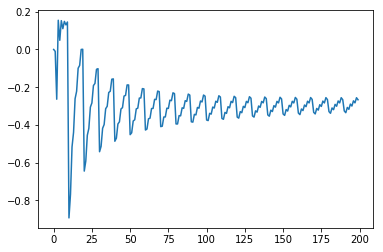

In [4]:
import matplotlib.pyplot as plt

result = foo.array_ana(values)
plt.plot(result['skew'])